In [1]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import numpy as np
import openmesh as om
import networkx as nx

In [2]:
%matplotlib widget

## Loading the mesh


In [3]:
# Loading the mesh
my_mesh_path = "./example_stl/cube.stl"
my_mesh = mesh.Mesh.from_file(my_mesh_path)

In [4]:
# Details of the mesh
vertices = my_mesh.vectors.reshape(-1,3)
vertices = np.unique(vertices, axis=0)
vertex_count = vertices.shape[0]

face_count   = my_mesh.vectors.shape[0]

print("Vertex Count: {}".format(vertex_count))
print("Face Count: {}".format(face_count))

Vertex Count: 8
Face Count: 12


### Plot

In [5]:
def plot3d(vectors):
    figure = plt.figure()
    plt.ion()
    axes = mplot3d.Axes3D(figure)
    # Attach the Mesh to the plot
    poly_3d_collection = mplot3d.art3d.Poly3DCollection(vectors)
    poly_3d_collection.set_edgecolors('black')
    axes.add_collection3d(poly_3d_collection)
    # Auto scale to the mesh size
    scale = my_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    # Show the plot to the screen
    plt.show()

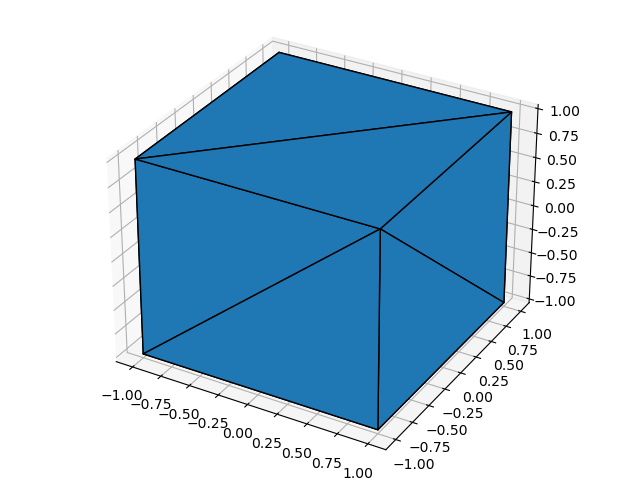

In [6]:
# Create a new plot
plot3d(my_mesh.vectors)

In [7]:
def openmesh_to_numpy_stl(om_mesh):
    return None

---

## Unfold the mesh

### 1. Read the Data by OpenMesh

In [8]:
# Read the mesh with openmesh for data structure utility
om_mesh = om.read_trimesh(my_mesh_path)
print("numEdges = {}".format(om_mesh.n_edges()))
print("numVertices = {}".format(om_mesh.n_vertices()))
print("numFaces = {}".format(om_mesh.n_faces()))

numEdges = 18
numVertices = 8
numFaces = 12


### 2. Create The Dual Graph

#### 2.1 Function to calculate Dual Graph Edge weight

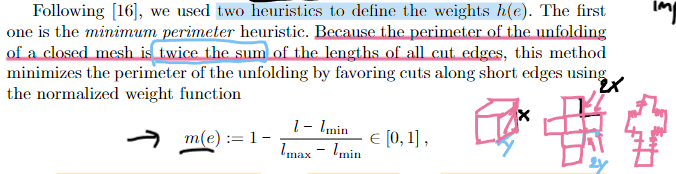

In [9]:
# Function to Calculate the Edge weight in dual graph
def calculate_dual_weight(edge, minLength, maxLength, om_mesh):
    edge_length = om_mesh.calc_edge_length(edge)
    weight = 1.0 - ( (edge_length - minLength)/(maxLength - minLength) )
    return weight

#### 2.2 Create Dual Graph

In [10]:
# Calculate the min and max edge length for weight calculation
minLength = 1000
maxLength = 0
for edge in om_mesh.edges():
    edgelength = om_mesh.calc_edge_length(edge) # OpenMesh : Get Edge Length
    if edgelength < minLength:
        minLength = edgelength
    if edgelength > maxLength:
        maxLength = edgelength

In [11]:
# Create Dual Graph
dual_graph = nx.Graph()

# Traverse the mesh by its adjacent face
# We need to traverse by using half edges for adjacent faces
for edge in om_mesh.edges():
    # Find the Halfedge of the edge
    halfedge_0 = om_mesh.halfedge_handle(edge, 0)
    halfedge_1 = om_mesh.halfedge_handle(edge, 1)
    
    # Extract Face corresponds to these halfedges
    face0 = om_mesh.face_handle(halfedge_0)
    face1 = om_mesh.face_handle(halfedge_1)
    
    dual_graph_edge_weight = calculate_dual_weight(edge, minLength, maxLength, om_mesh)
    
    center1 = (0, 0)
    for vertex in om_mesh.fv(face0):
        center1 = center1 + 0.3333333333333333 * np.array([om_mesh.point(vertex)[0], om_mesh.point(vertex)[2]])
    center2 = (0, 0)
    for vertex in om_mesh.fv(face1):
        center2 = center2 + 0.3333333333333333 * np.array([om_mesh.point(vertex)[0], om_mesh.point(vertex)[2]])

    # [4.5] Add the EDGE and "TWO NODES" to the dual graph
    # - Füge die neuen Knoten und Kante zum dualen Graph hinzu
    dual_graph.add_node(face0.idx(), pos=center1)
    dual_graph.add_node(face1.idx(), pos=center2)
    
    dual_graph.add_edge(face0.idx(), face1.idx(), idx=edge.idx(), weight=dual_graph_edge_weight)

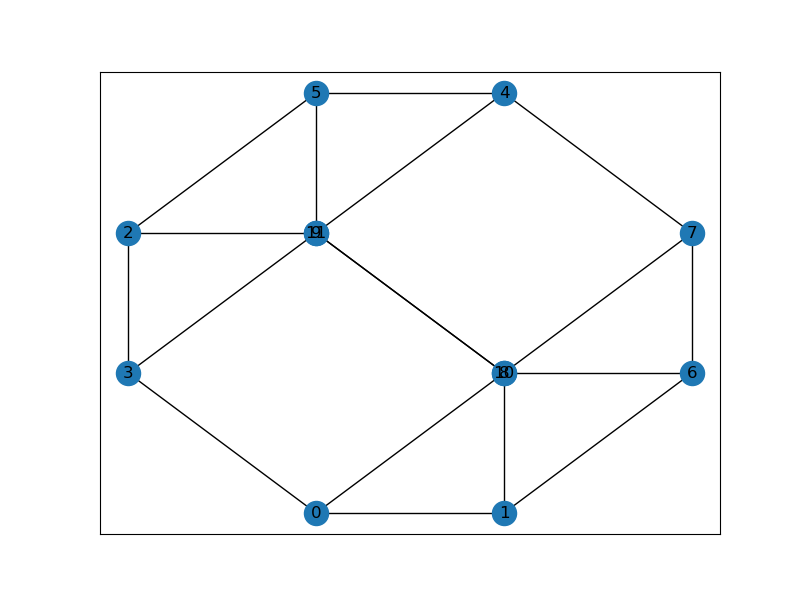

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
pos=nx.get_node_attributes(dual_graph,'pos')
nx.draw_networkx(dual_graph,pos)

#### 2.3 Create Minimum Spanning Tree

In [13]:
spanning_tree = nx.minimum_spanning_tree(dual_graph)

In [17]:
spanning_tree.edges()

EdgeView([(0, 1), (0, 3), (0, 10), (3, 2), (3, 9), (1, 6), (10, 11), (8, 9), (6, 7), (2, 5), (5, 4)])

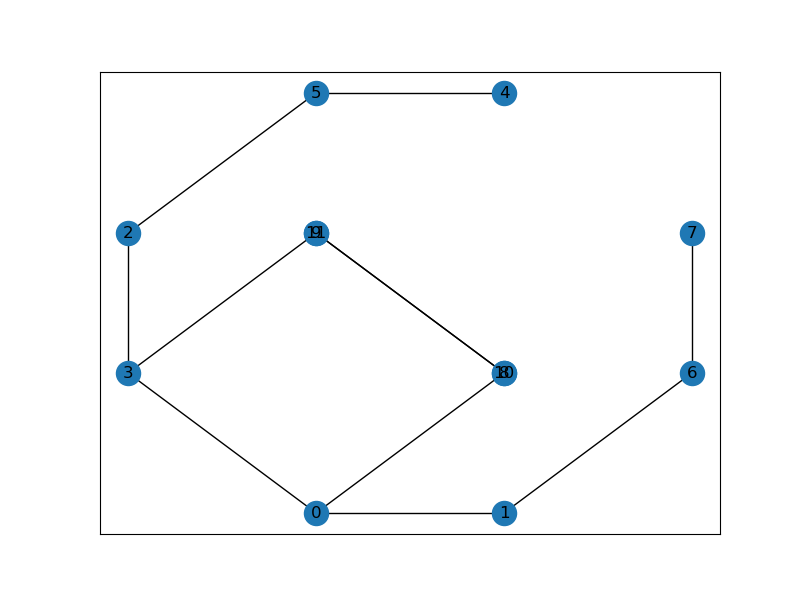

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
pos=nx.get_node_attributes(spanning_tree,'pos')
nx.draw_networkx(spanning_tree, pos)

#### 2.4 Unfold the Spanning Tree

In [ ]:
def unfold_spanning_tree(om_mesh, spanning_tree):
    """
    Given OpenMesh object and Nx's Spanning Tree of Dual Graph
    Return New OpenMesh object of Unfolded Mesh
    """
    # Create New result mesh 
    unfolded_mesh = om.TriMesh()
    
    # Old mesh detail
    original_face_count = om_mesh.n_faces()
    tree_size = spanning_tree.number_of_edges()
    
    # How Many Edge to draw after Unfold
    num_unfolded_edge = (3*original_face_count) - tree_size
    
    # Arrays 
    # - Detemines is this folding or cut
    is_folding_edge = np.zeros(num_unfolded_edge, dtype=bool)
    # - Gluing Edge (which edge need to glue together)
    glue_number     = np.zeros(num_unfolded_edge, dtype=int)
    # - Folded or Creased Edge (which edge need to be folded or creased)
    folding_type    = np.zeros(num_unfolded_edge, dtype=int)
    # - Connections between faces, connections[face_idx] = face
    connections = np.empty(original_face_count, dtype=int)
    
    # Start Now ! from Spanning Tree
    # Node = faces
    # Edge = edge adjacent, cousing by two faces
    starting_node = list(spanning_tree.nodes())[0] # Select from Spanning Tree
    starting_triangle = mesh.face_handle(starting_node) # Face = Triangle -w-"
    
    #
    
    